<a href="https://colab.research.google.com/github/HaqTetsuya/rusdi-prototype-1/blob/greeting_test/rusdi_prototype_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Teks judul default
# Cell 1: Instalasi library yang diperlukan
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm

In [ ]:
# @title Cell 2: Import library yang diperlukan
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from google.colab import drive, files

In [ ]:
# @title Cell 3: Mount Google Drive untuk menyimpan model dan data
# Uncomment ini jika ingin menggunakan Google Drive

drive.mount('/content/drive')
MODEL_SAVE_PATH = "/content/drive/MyDrive/indobert_intent_model"



# Cell 4: Kelas Dataset untuk IndoBERT
class IntentDataset(Dataset):
    """Dataset untuk klasifikasi intent dengan IndoBERT"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert dict of tensors to flat tensors
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)

        return item



Mounted at /content/drive


In [ ]:
# @title Cell 5: Fungsi untuk membuat contoh file CSV
def create_sample_csv(output_file="sample_intent_data.csv"):
    """Membuat contoh file CSV dengan data intent untuk demonstrasi"""

    data = {
        'text': [
            "Bagaimana cara meminjam buku di perpustakaan?",
            "Apa jam buka perpustakaan hari ini?",
            "Berapa lama masa peminjaman buku?",
            "Saya ingin memperpanjang peminjaman buku",
            "Bagaimana cara menjadi anggota perpustakaan?",
            "Berapa denda untuk keterlambatan pengembalian?",
            "Apakah perpustakaan mempunyai ruang belajar?",
            "Bagaimana cara mencari buku tentang sejarah Indonesia?",
            "Apakah perpustakaan memiliki layanan e-book?",
            "Saya kehilangan kartu anggota perpustakaan",
            "Bagaimana cara mengakses jurnal ilmiah?",
            "Dimana letak koleksi buku referensi?",
            "Apakah ada acara diskusi buku minggu ini?",
            "Berapa buku maksimal yang bisa dipinjam?",
            "Saya ingin memesan buku yang sedang dipinjam",
            "Apakah ada WiFi gratis di perpustakaan?",
            "Berapa biaya fotokopi dokumen di perpustakaan?",
            "Saya ingin mendonasikan buku ke perpustakaan",
            "Bagaimana cara menggunakan komputer di perpustakaan?",
            "Apakah perpustakaan punya koleksi tesis dan disertasi?",
            "Saya ingin mengajukan permintaan buku baru",
            "Bisakah saya meminjam buku antar-perpustakaan?",
            "Apa syarat menjadi anggota perpustakaan?",
            "Bagaimana cara mencari artikel jurnal?",
            "Apakah ada fasilitas printer di perpustakaan?",
            "Berapa lama waktu operasional perpustakaan?",
            "Saya ingin melaporkan kerusakan buku",
            "Bagaimana proses pengembalian buku?",
            "Apakah layanan peminjaman tersedia online?",
            "Dimana saya bisa menemukan kamus bahasa asing?"
        ],
        'intent': [
            "peminjaman_buku",
            "jam_operasional",
            "masa_peminjaman",
            "perpanjangan",
            "pendaftaran_anggota",
            "denda",
            "fasilitas",
            "pencarian_buku",
            "layanan_digital",
            "kehilangan_kartu",
            "akses_jurnal",
            "lokasi_koleksi",
            "agenda_perpustakaan",
            "kuota_peminjaman",
            "reservasi_buku",
            "fasilitas",
            "biaya_layanan",
            "donasi_buku",
            "penggunaan_fasilitas",
            "koleksi_khusus",
            "permintaan_buku",
            "peminjaman_antar_perpustakaan",
            "pendaftaran_anggota",
            "pencarian_jurnal",
            "fasilitas",
            "jam_operasional",
            "laporan_masalah",
            "pengembalian_buku",
            "layanan_online",
            "lokasi_koleksi"
        ]
    }

    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)
    print(f"File contoh CSV berhasil dibuat: {output_file}")
    return output_file


In [51]:

# @title Cell 6: Fungsi untuk memuat data dari CSV
def load_data_from_csv(csv_path):
    """Memuat data intent dari file CSV"""
    print(f"Memuat data dari: {csv_path}")

    # Cek apakah file ada
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File CSV tidak ditemukan: {csv_path}")

    # Memuat data
    try:
        df = pd.read_csv(csv_path)
        print(f"Berhasil memuat {len(df)} baris data")
    except Exception as e:
        raise Exception(f"Error saat memuat file CSV: {str(e)}")

    # Cek kolom yang diperlukan
    required_columns = ['text', 'intent']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Kolom '{col}' tidak ditemukan dalam file CSV")

    # Mengonversi label intent menjadi angka
    label_encoder = LabelEncoder()
    df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

    # Informasi tentang intent yang ditemukan
    intent_classes = label_encoder.classes_
    num_labels = len(intent_classes)
    print(f"Ditemukan {num_labels} intent berbeda dalam dataset")

    # Tampilkan distribusi intent
    intent_counts = df['intent'].value_counts()
    print("\nDistribusi intent:")
    for intent, count in intent_counts.items():
        print(f"  {intent}: {count} contoh")

    # Membagi data menjadi training dan validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['intent'])

    print(f"Data dibagi menjadi {len(train_df)} sampel training dan {len(val_df)} sampel validasi")

    # Menyiapkan data untuk pelatihan
    train_texts = train_df['text'].values
    train_labels = train_df['intent_encoded'].values
    val_texts = val_df['text'].values
    val_labels = val_df['intent_encoded'].values

    return train_texts, val_texts, train_labels, val_labels, intent_classes, num_labels, label_encoder


In [53]:
# @title Cell 7: Fungsi untuk setup model IndoBERT
def setup_indobert_for_intent(num_labels):
    """Load model IndoBERT untuk klasifikasi intent"""

    print("Memuat model IndoBERT...")
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    model = AutoModelForSequenceClassification.from_pretrained(
        "indobenchmark/indobert-base-p1",
        num_labels=num_labels
    )
    print("Model berhasil dimuat")

    return model, tokenizer

In [54]:
import os
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import get_scheduler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

def train_intent_classifier(model, tokenizer, train_texts, train_labels, val_texts, val_labels,
                           batch_size=16, epochs=10, learning_rate=2e-5, weight_decay=0.01,
                           save_path=MODEL_SAVE_PATH, use_class_weights=True, patience=3):
    """
    Melatih model IndoBERT untuk klasifikasi intent dengan perbaikan:
    - Early stopping
    - Weight decay untuk regularisasi
    - Class weights untuk mengatasi imbalance
    - Monitoring metrics yang lebih komprehensif (loss, accuracy, F1, precision, recall)
    - Learning rate scheduler yang lebih sophisticated
    """

    # Persiapkan dataset
    print("Menyiapkan dataset...")
    train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Compute class weights if needed
    if use_class_weights:
        # Get unique classes
        unique_classes = np.unique(train_labels)
        # Compute weights
        weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=train_labels
        )
        # Convert to tensor
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        class_weights = torch.FloatTensor(weights).to(device)
        print(f"Menggunakan class weights: {weights}")
    else:
        class_weights = None

    # Optimizer dengan weight decay untuk regularisasi
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler dengan warmup
    num_training_steps = len(train_dataloader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
    scheduler = get_scheduler("cosine", optimizer=optimizer,
                             num_warmup_steps=num_warmup_steps,
                             num_training_steps=num_training_steps)

    # Cek untuk GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Menggunakan device: {device}")
    model.to(device)
    print(f"Mulai pelatihan model...")
    print(f"Total epoch: {epochs}, batch size: {batch_size}, learning rate: {learning_rate}, weight decay: {weight_decay}")

    # Create loss function with class weights if needed
    if class_weights is not None:
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    else:
        loss_fn = torch.nn.CrossEntropyLoss()

    # Logging training
    best_val_loss = float('inf')
    counter = 0  # Counter for early stopping
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        tqdm.write(f"\nEpoch {epoch+1}/{epochs} - Training dimulai...")
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for batch in progress_bar:
            try:
                # Pindahkan batch ke device
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                # Forward pass with custom loss function
                optimizer.zero_grad()

                # Modified to use our loss function instead of the model's default
                outputs = model(**inputs)
                logits = outputs.logits
                loss = loss_fn(logits, labels)

                # Backward pass
                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

            except RuntimeError as e:
                if "out of memory" in str(e):
                    tqdm.write("Peringatan: Kehabisan memori! Membersihkan cache...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        avg_train_loss = train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        tqdm.write(f"Epoch {epoch+1}/{epochs} - Validasi dimulai...")
        progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

        with torch.no_grad():
            for batch in progress_bar:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                outputs = model(**inputs)
                logits = outputs.logits
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

                # Hitung akurasi
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

                # Collect predictions and labels for metrics
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        # Calculate metrics
        avg_val_loss = val_loss / len(val_dataloader)
        accuracy = correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Save metrics to history
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(accuracy)
        history['val_f1'].append(f1)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)

        # Print detailed metrics
        tqdm.write(f"Epoch {epoch+1}/{epochs}:")
        tqdm.write(f"  Train Loss: {avg_train_loss:.4f}")
        tqdm.write(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy*100:.2f}%")
        tqdm.write(f"  Val F1: {f1:.4f}, Val Precision: {precision:.4f}, Val Recall: {recall:.4f}")

        # Early stopping and model saving logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0  # Reset early stopping counter

            if not os.path.exists(save_path):
                os.makedirs(save_path)

            tqdm.write(f"Menyimpan model terbaik ke {save_path}")
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)

            # Save classification report for best model
            report = classification_report(all_labels, all_preds, output_dict=True)
            with open(os.path.join(save_path, "classification_report.json"), 'w') as f:
                json.dump(report, f, indent=4)
        else:
            counter += 1
            tqdm.write(f"Validation loss tidak membaik. Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                tqdm.write(f"Early stopping triggered setelah {epoch+1} epochs")
                break

    tqdm.write(f"Pelatihan selesai! Model terbaik disimpan di {save_path}")

    # Simpan history ke file JSON
    history_file = os.path.join(save_path, "training_history.json")
    with open(history_file, 'w') as f:
        json.dump(history, f)
    tqdm.write(f"History training disimpan di {history_file}")

    # Plot hasil training
    plot_training_results(history, save_path)

    return model, history

def plot_training_results(history, save_path):
    """Plot dan simpan hasil training metrics"""
    plt.figure(figsize=(15, 10))

    # Plot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
    plt.title('Akurasi selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['val_f1'], label='Validation F1', marker='o', color='purple')
    plt.title('F1 Score selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Plot 4: Precision & Recall
    plt.subplot(2, 2, 4)
    plt.plot(history['val_precision'], label='Validation Precision', marker='o', color='orange')
    plt.plot(history['val_recall'], label='Validation Recall', marker='o', color='brown')
    plt.title('Precision & Recall selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(save_path, "training_metrics.png"))
    plt.show()

In [55]:
# @title Cell 9: Fungsi untuk evaluasi model
def evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes, batch_size=16):
    """Evaluasi model dan tampilkan confusion matrix dan metrics"""

    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluasi"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=intent_classes, digits=4)
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=intent_classes, yticklabels=intent_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return report, cm


In [56]:
# @title Cell 10: Fungsi untuk prediksi intent
def predict_intent(text, model, tokenizer, intent_classes, label_encoder=None, device=None):
    """Memprediksi intent dari teks input"""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    predicted_intent = intent_classes[prediction]

    # Dapatkan top 3 intent dengan confidence tertinggi
    top_k = 3
    if len(intent_classes) < top_k:
        top_k = len(intent_classes)

    topk_values, topk_indices = torch.topk(probabilities, top_k, dim=1)
    topk_intents = [(intent_classes[idx.item()], val.item()) for idx, val in zip(topk_indices[0], topk_values[0])]

    return predicted_intent, confidence, topk_intents

In [57]:
# @title Cell 11: Fungsi untuk latih
import os
import pickle

def run_full_pipeline(use_drive=True):
    """Jalankan pipeline lengkap: buat contoh, latih model, evaluasi"""

    # Buat folder jika belum ada
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

    # 1. Buat atau muat dataset
    csv_file = "sample_intent_data.csv"
    if not os.path.exists(csv_file):
        csv_file = create_sample_csv(csv_file)

    # 2. Muat data
    train_texts, val_texts, train_labels, val_labels, intent_classes, num_labels, label_encoder = load_data_from_csv(csv_file)

    # 3. Setup model
    model, tokenizer = setup_indobert_for_intent(num_labels)

    # 4. Latih model
    model, history = train_intent_classifier(
        model,
        tokenizer,
        train_texts,
        train_labels,
        val_texts,
        val_labels,
        batch_size=16,
        epochs=10,  # Increased epochs with early stopping
        learning_rate=2e-5,  # Reduced learning rate
        weight_decay=0.01,  # Added regularization
        patience=3  # Early stopping after 3 epochs without improvement
    )

    # 5. Evaluasi model
    report, cm = evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes)

    # 6. Simpan intent classes & label encoder
    with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "wb") as f:
        pickle.dump(intent_classes, f)

    with open(f"{MODEL_SAVE_PATH}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    print(f"\n✅ Model telah berhasil dilatih dan disimpan di {MODEL_SAVE_PATH}")
    print(f"Jumlah intent: {num_labels}")
    print(f"Intent yang didukung: {', '.join(intent_classes)}")

    return model, tokenizer, intent_classes, label_encoder


In [61]:
# @title Cell 12: Fungsi untuk demo prediksi
def run_prediction_demo(model=None, tokenizer=None, intent_classes=None, label_encoder=None):
    """Jalankan demo prediksi intent dengan model yang telah dilatih"""

    # Jika model tidak diberikan, muat dari path penyimpanan
    if model is None or tokenizer is None or intent_classes is None:
        if not os.path.exists(MODEL_SAVE_PATH):
            print(f"Error: Model tidak ditemukan di {MODEL_SAVE_PATH}")
            print("Jalankan run_full_pipeline() terlebih dahulu untuk melatih model")
            return

        # Muat model dan tokenizer
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
        tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)

        # Muat intent classes
        import pickle
        with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "rb") as f:
            intent_classes = pickle.load(f)

    # Contoh pertanyaan untuk demo
    test_texts = [
        # GREETING Variations
        "Halo!",
        "Hai, apa kabar?",
        "Selamat pagi!",
        "Sore, bro!",
        "Malam guys!",
        "Woi, ada yang bisa bantu?",
        "Hey, gimana kabarnya?",
        "Yo, lagi apa?",
        "Permisi, boleh nanya?",
        "Halo teman-teman!",
        "Lama gak ketemu, gimana kabar lo?",
        "Udah lama ga ngobrol, yuk ngobrol!",
        "Baru datang nih, ada yang seru?",

        # GOODBYE Variations
        "Oke, sampai jumpa!",
        "Dadah, gue cabut dulu!",
        "Makasih ya, sampai nanti!",
        "Bye, ketemu lagi besok!",
        "Udah dulu ya, selamat malam!",
        "Saya keluar dulu, sampai jumpa!",
        "Dah bro, take care!",
        "Terima kasih, saya pamit dulu!",
        "Ok bos, gue out dulu!",
        "Sampai ketemu lagi di lain waktu!",
        "Sudah dulu ya, lanjut lain kali!",

        # Ambiguous Cases (Bisa greeting atau goodbye)
        "Baru masuk nih, ada apa aja?",   # Bisa dianggap greeting (baru datang)
        "Baru keluar nih, hati-hati ya!",  # Bisa dianggap goodbye (tapi bukan diri sendiri yang pergi)
        "Sampai jumpa lagi, tapi sebelumnya aku mau nanya",  # Ada goodbye tapi masih lanjut ngobrol
        "Halo, tapi sebentar lagi aku pergi",  # Ada greeting dan goodbye dalam satu kalimat
        "Wah, kayaknya aku harus cabut, tapi bentar deh",  # Indikasi goodbye tapi masih ragu
        "Eh, aku baru datang, tapi kalian udah mau pergi ya?",  # Greeting dan goodbye dalam satu konteks
    ]

    print("Demo Prediksi Intent:")



    # Prediksi dari contoh
    for text in test_texts:
        intent, confidence, topk = predict_intent(text, model, tokenizer, intent_classes)
        print(f"\nInput: \"{text}\"")
        print(f"Intent terdeteksi: {intent} (confidence: {confidence:.4f})")
        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(topk):
            print(f"  {i+1}. {intent_name}: {score:.4f}")

    # Prediksi input pengguna
    while True:
        user_input = input("\nMasukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): ")
        if user_input.lower() == 'exit':
            break

        intent, confidence, topk = predict_intent(user_input, model, tokenizer, intent_classes)
        print(f"Intent terdeteksi: {intent} (confidence: {confidence:.4f})")
        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(topk):
            print(f"  {i+1}. {intent_name}: {score:.4f}")



Memuat data dari: sample_intent_data.csv
Berhasil memuat 1684 baris data
Ditemukan 3 intent berbeda dalam dataset

Distribusi intent:
  goodbye: 610 contoh
  confirm: 544 contoh
  greeting: 530 contoh
Data dibagi menjadi 1347 sampel training dan 337 sampel validasi
Memuat model IndoBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model berhasil dimuat
Menyiapkan dataset...
Menggunakan class weights: [1.03218391 0.92008197 1.05896226]
Menggunakan device: cuda
Mulai pelatihan model...
Total epoch: 10, batch size: 16, learning rate: 2e-05, weight decay: 0.01

Epoch 1/10 - Training dimulai...


Epoch 1/10 - Validasi dimulai...


Epoch 1/10:
  Train Loss: 0.7402
  Val Loss: 0.3037, Val Accuracy: 89.32%
  Val F1: 0.8941, Val Precision: 0.9038, Val Recall: 0.8932
Menyimpan model terbaik ke /content/drive/MyDrive/indobert_intent_model

Epoch 2/10 - Training dimulai...


Epoch 2/10 - Validasi dimulai...


Epoch 2/10:
  Train Loss: 0.2300
  Val Loss: 0.2247, Val Accuracy: 91.39%
  Val F1: 0.9143, Val Precision: 0.9154, Val Recall: 0.9139
Menyimpan model terbaik ke /content/drive/MyDrive/indobert_intent_model

Epoch 3/10 - Training dimulai...


Epoch 3/10 - Validasi dimulai...


Epoch 3/10:
  Train Loss: 0.0789
  Val Loss: 0.3362, Val Accuracy: 92.28%
  Val F1: 0.9231, Val Precision: 0.9252, Val Recall: 0.9228
Validation loss tidak membaik. Early stopping counter: 1/3

Epoch 4/10 - Training dimulai...


Epoch 4/10 - Validasi dimulai...


Epoch 4/10:
  Train Loss: 0.0596
  Val Loss: 0.2982, Val Accuracy: 92.88%
  Val F1: 0.9290, Val Precision: 0.9302, Val Recall: 0.9288
Validation loss tidak membaik. Early stopping counter: 2/3

Epoch 5/10 - Training dimulai...


Epoch 5/10 - Validasi dimulai...


Epoch 5/10:
  Train Loss: 0.0209
  Val Loss: 0.3644, Val Accuracy: 93.18%
  Val F1: 0.9316, Val Precision: 0.9326, Val Recall: 0.9318
Validation loss tidak membaik. Early stopping counter: 3/3
Early stopping triggered setelah 5 epochs
Pelatihan selesai! Model terbaik disimpan di /content/drive/MyDrive/indobert_intent_model
History training disimpan di /content/drive/MyDrive/indobert_intent_model/training_history.json


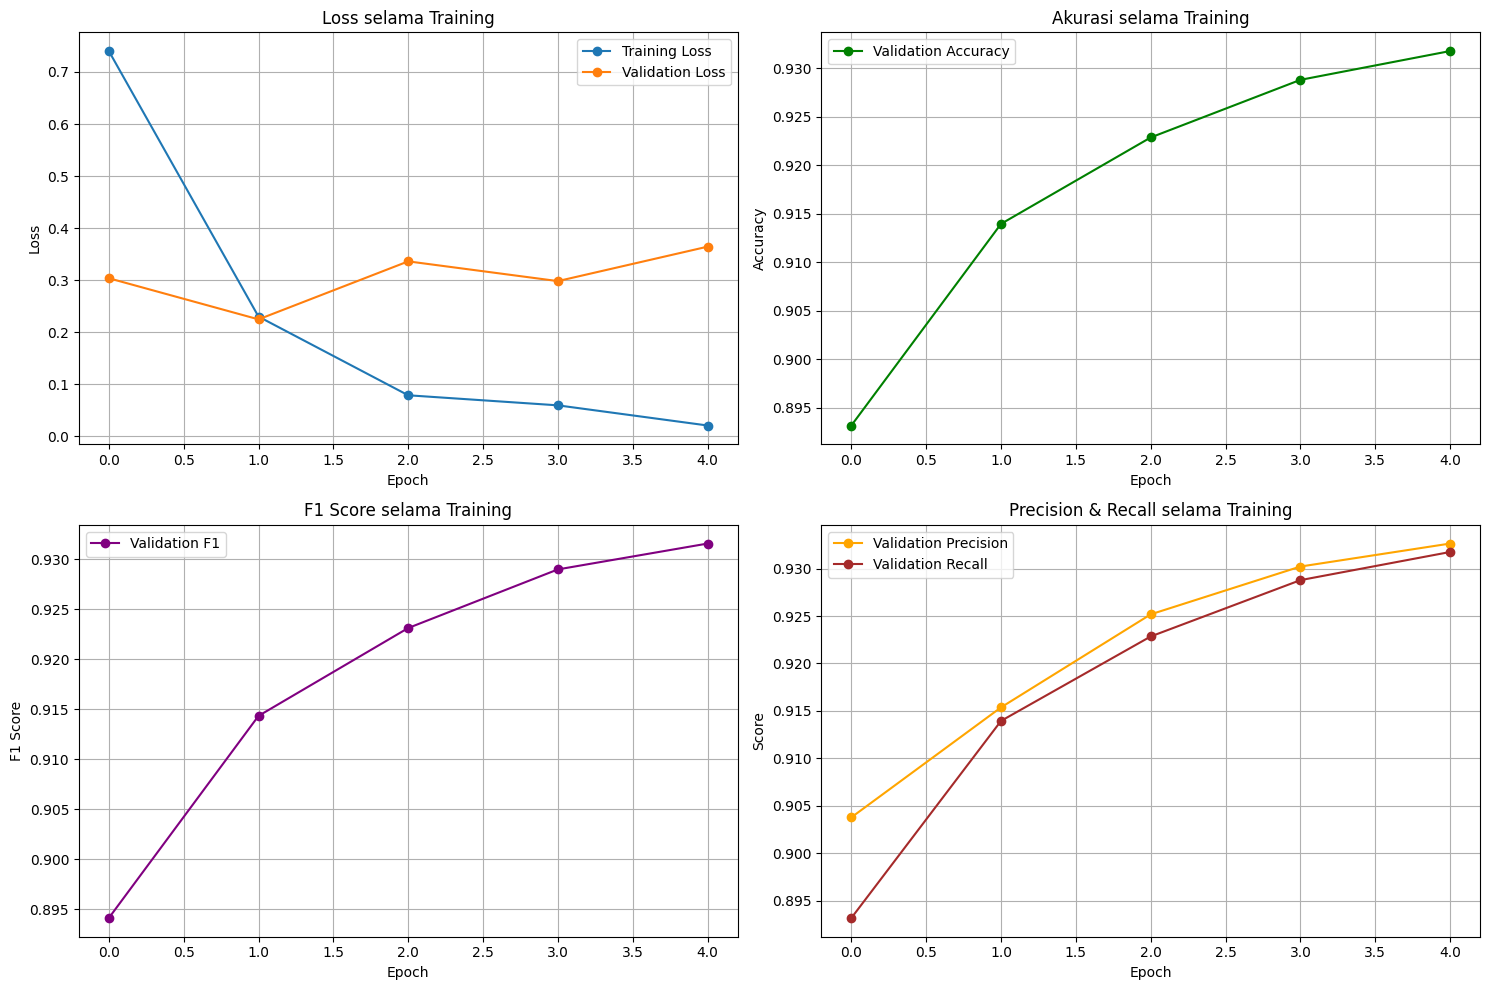

Evaluasi: 100%|██████████| 22/22 [00:02<00:00,  8.96it/s]


Classification Report:
              precision    recall  f1-score   support

     confirm     0.8966    0.9541    0.9244       109
     goodbye     0.9590    0.9590    0.9590       122
    greeting     0.9394    0.8774    0.9073       106

    accuracy                         0.9318       337
   macro avg     0.9317    0.9302    0.9303       337
weighted avg     0.9326    0.9318    0.9316       337



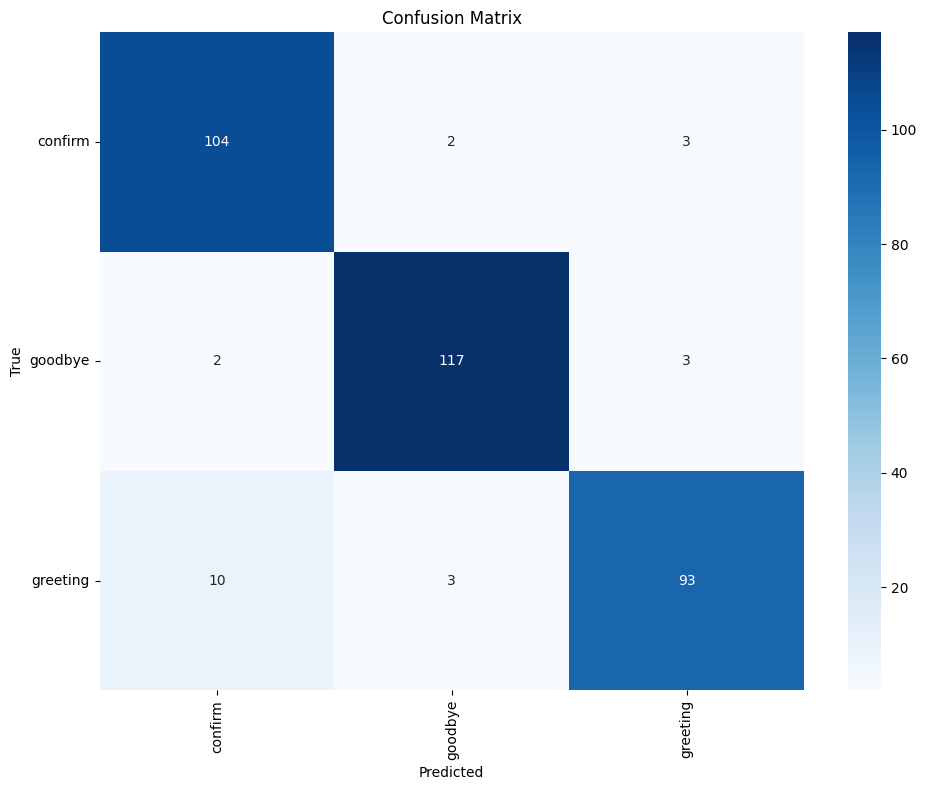


✅ Model telah berhasil dilatih dan disimpan di /content/drive/MyDrive/indobert_intent_model
Jumlah intent: 3
Intent yang didukung: confirm, goodbye, greeting


In [59]:
# Cell 13: Jalankan pipeline (uncomment untuk menjalankan)

model, tokenizer, intent_classes, label_encoder = run_full_pipeline()


# Cell 14: Jalankan demo prediksi (uncomment untuk menjalankan)


In [ ]:

run_prediction_demo(model, tokenizer, intent_classes, label_encoder)


Demo Prediksi Intent:

Input: "Halo!"
Intent terdeteksi: greeting (confidence: 0.9996)
Top 3 intent:
  1. greeting: 0.9996
  2. goodbye: 0.0002
  3. confirm: 0.0002

Input: "Hai, apa kabar?"
Intent terdeteksi: greeting (confidence: 0.9997)
Top 3 intent:
  1. greeting: 0.9997
  2. goodbye: 0.0002
  3. confirm: 0.0001

Input: "Selamat pagi!"
Intent terdeteksi: greeting (confidence: 0.9996)
Top 3 intent:
  1. greeting: 0.9996
  2. goodbye: 0.0003
  3. confirm: 0.0002

Input: "Sore, bro!"
Intent terdeteksi: greeting (confidence: 0.9996)
Top 3 intent:
  1. greeting: 0.9996
  2. goodbye: 0.0003
  3. confirm: 0.0002

Input: "Malam guys!"
Intent terdeteksi: greeting (confidence: 0.9996)
Top 3 intent:
  1. greeting: 0.9996
  2. goodbye: 0.0002
  3. confirm: 0.0002

Input: "Woi, ada yang bisa bantu?"
Intent terdeteksi: greeting (confidence: 0.9997)
Top 3 intent:
  1. greeting: 0.9997
  2. goodbye: 0.0002
  3. confirm: 0.0001

Input: "Hey, gimana kabarnya?"
Intent terdeteksi: greeting (confidence

In [60]:
# @title Augmentasi Dataset NLP
import pandas as pd
import random
import nltk
from deep_translator import GoogleTranslator
from nltk.corpus import wordnet
from collections import defaultdict, Counter

nltk.download('omw-1.4')
nltk.download('wordnet')

# Load dataset
file_path = "/content/aaa.csv"  # Sesuaikan dengan lokasi file
df = pd.read_csv(file_path)

# Fungsi mendapatkan sinonim dari WordNet
def get_synonym(word):
    synonyms = set()
    for syn in wordnet.synsets(word, lang='ind'):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Fungsi mengganti kata dengan sinonim
def replace_with_synonym(sentence):
    words = sentence.split()
    new_words = [random.choice(get_synonym(word)) if get_synonym(word) else word for word in words]
    return " ".join(new_words)

# Fungsi backtranslation
def back_translate(sentence):
    translated = GoogleTranslator(source='id', target='en').translate(sentence)
    return GoogleTranslator(source='en', target='id').translate(translated)

# Fungsi menambahkan typo
def add_typo(sentence):
    chars = list(sentence)
    if len(chars) > 3:
        idx = random.randint(0, len(chars) - 1)
        chars[idx] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)

# Fungsi random deletion (hapus kata acak)
def random_deletion(sentence, p=0.3):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = [word for word in words if random.uniform(0, 1) > p]
    return " ".join(new_words) if new_words else random.choice(words)

# Fungsi random swap (tukar kata acak)
def random_swap(sentence, n=1):
    words = sentence.split()
    if len(words) < 2:
        return sentence
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return " ".join(words)

# Fungsi phonetic augmentation (ubah ejaan fonetik/slang)
def phonetic_augmentation(sentence):
    phonetic_dict = {
        "saya": "sy", "kamu": "km", "oke": "ok", "ga": "g", "ya": "y",
        "dong": "dongz", "bro": "brow", "please": "plis", "bisa": "bs", "selamat": "slmt"
    }
    words = sentence.split()
    new_words = [phonetic_dict[word] if word in phonetic_dict else word for word in words]
    return " ".join(new_words)

# Fungsi menambahkan kata atau frasa umum
def add_common_phrase(sentence):
    common_phrases = ["ya", "anjay", "dong", "cuy", "bro", "lah", "plis", "eh"]
    return sentence + " " + random.choice(common_phrases)

# Fungsi augmentasi data dengan berbagai metode
def augment_data(text):
    augmented_texts = []
    augmented_texts.append(text)  # Data asli
    augmented_texts.append(replace_with_synonym(text))  # Sinonim
    augmented_texts.append(back_translate(text))  # Backtranslation
    augmented_texts.append(add_typo(text))  # Typo
    augmented_texts.append(random_deletion(text))  # Hapus kata acak
    augmented_texts.append(random_swap(text))  # Tukar kata acak
    augmented_texts.append(phonetic_augmentation(text))  # Ubah ejaan fonetik/slang
    augmented_texts.append(add_common_phrase(text))  # Tambahkan frasa umum
    return list(set(augmented_texts))  # Hindari duplikasi

# Pelacakan jumlah augmentasi
augment_count = defaultdict(int)
intent_distribution = defaultdict(int)

# Proses augmentasi
augmented_rows = []
for _, row in df.iterrows():
    texts = augment_data(row['text'])
    augment_count[row['text']] = len(texts)  # Hitung jumlah augmentasi per teks
    intent_distribution[row['intent']] += len(texts)  # Hitung distribusi intent
    for new_text in texts:
        augmented_rows.append([new_text, row['intent']])

# Simpan dataset baru
augmented_df = pd.DataFrame(augmented_rows, columns=["text", "intent"])
augmented_df.to_csv("/content/sample_intent_data.csv", index=False)

# Statistik Augmentasi
print("✅ Augmentasi selesai! Dataset baru tersimpan sebagai 'sample_intent_data.csv'.")
print(f"📌 Jumlah data sebelum augmentasi: {len(df)}")
print(f"📌 Jumlah data setelah augmentasi: {len(augmented_df)}")

# Cek rata-rata augmentasi per teks
augment_avg = sum(augment_count.values()) / len(augment_count)
print(f"📊 Rata-rata augmentasi per teks: {augment_avg:.2f}")

# Cek distribusi intent setelah augmentasi
print("\n📈 Distribusi intent setelah augmentasi:")
for intent, count in intent_distribution.items():
    print(f"  {intent}: {count} contoh")


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Augmentasi selesai! Dataset baru tersimpan sebagai 'sample_intent_data.csv'.
📌 Jumlah data sebelum augmentasi: 300
📌 Jumlah data setelah augmentasi: 1684
📊 Rata-rata augmentasi per teks: 5.62

📈 Distribusi intent setelah augmentasi:
  greeting: 528 contoh
  goodbye: 610 contoh
  confirm: 546 contoh


In [ ]:
!pip install deep-translator


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
# prompt: the model already trained and saved to drive, but can i test the model without running thee training.

# Path ke folder model di Google Drive
model_path = "/content/drive/MyDrive/indobert_intent_model"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load intent classes
with open(f"{model_path}/intent_classes.pkl", "rb") as f:
    intent_classes = pickle.load(f)

# Load label encoder (jika diperlukan)
with open(f"{model_path}/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


def predict_intent(text, model, tokenizer, intent_classes, device=None):
    """Memprediksi intent dari teks input"""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    predicted_intent = intent_classes[prediction]

    # Dapatkan top 3 intent dengan confidence tertinggi
    top_k = 3
    if len(intent_classes) < top_k:
        top_k = len(intent_classes)

    topk_values, topk_indices = torch.topk(probabilities, top_k, dim=1)
    topk_intents = [(intent_classes[idx.item()], val.item()) for idx, val in zip(topk_indices[0], topk_values[0])]

    return predicted_intent, confidence, topk_intents


# Contoh penggunaan
    while True:
        user_input = input("\nMasukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): ")
        if user_input.lower() == 'exit':
            break

        intent, confidence, topk = predict_intent(user_input, model, tokenizer, intent_classes)
        print(f"Intent terdeteksi: {intent} (confidence: {confidence:.4f})")
        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(topk):
            print(f"  {i+1}. {intent_name}: {score:.4f}")

